In [2]:
# Python
import pandas as pd
from tqdm import tqdm
import time
from matplotlib.dates import date2num
import matplotlib.pyplot as plt
from prophet import Prophet
import mysql
import mysql.connector
import pymysql
import joblib
import dyplot
from datetime import datetime
from sklearn.metrics import mean_absolute_error


In [3]:
query = f"""SELECT fecha,tmed
FROM valores_climatologicos
"""

In [4]:
database = "AEMET"

db = mysql.connector.connect(host     = "localhost",
                             user     = "root",
                             password = "nueva_contraseña",
                             database = database)

cursor = db.cursor()

cursor.execute(query) # Ejecutamos la query
column_names = cursor.column_names # Nombre de las columnas de la tabla

# Guardamos los datos de la tabla
data = cursor.fetchall()


df = pd.DataFrame(data, columns = column_names)

cursor.close()
db.close()

In [5]:
#pasamos la columna fecha a datetime
df["fecha"] = pd.to_datetime(df["fecha"])

# SEMESTRAL:

In [7]:
#copiamos dos dataframes
df1 = df.copy()


In [8]:
#agrupamos por semestres
df1["fecha"] = df1['fecha'].apply(lambda x: pd.Timestamp(year=x.year, month=(1 if x.month <= 6 else 7), day=1))
df1 = df1.groupby("fecha").agg({"tmed": "mean"}).reset_index()


In [9]:

#sacar df entre df1 y df
last_date_df = df1["fecha"].max()
df_filtered = df[df["fecha"] > last_date_df]
df_filtered

# Ordena el nuevo DataFrame por fecha (si no está ordenado)
df_filtered = df_filtered.sort_values(by="fecha")

# Obtén la última fecha del nuevo Dataframe.
ultima_fecha = df_filtered["fecha"].max()

# Filtra las filas correspondientes a la última fecha
df_ultima_fecha = df_filtered[df_filtered["fecha"] == ultima_fecha]

# Calcula el promedio de la columna 'tmed' para esa fecha
promedio_tmed = df_filtered["tmed"].mean()

# Crea una fila con el promedio
resultado = pd.DataFrame({"fecha": [ultima_fecha], "tmed": [promedio_tmed]})

df_biannual = pd.concat([df1,resultado])
df_biannual = df_biannual.reset_index(drop=True)
df_biannual.rename(columns={"fecha": "ds", "tmed": "y"}, inplace=True)


In [10]:
df_biannual

,ds,y
0,2013-01-01,11.939553
1,2013-07-01,17.126592
2,2014-01-01,13.323046
3,2014-07-01,17.316944
4,2015-01-01,13.221510
5,2015-07-01,17.887790
6,2016-01-01,12.880579
7,2016-07-01,17.641331
8,2017-01-01,13.928824
9,2017-07-01,17.359126


In [11]:
#MODELO

m = Prophet()
m.fit(df_biannual)

22:28:16 - cmdstanpy - INFO - Chain [1] start processing
22:28:16 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
joblib.dump(m, 'prophet_biannual.pkl')

print("Modelo guardado con joblib")

Modelo guardado con joblib


In [13]:
future = m.make_future_dataframe(periods=14)
future.tail()

,ds
34,2024-11-11
35,2024-11-12
36,2024-11-13
37,2024-11-14
38,2024-11-15


In [14]:
forecast_biannual = m.predict(future)
forecast_biannual[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2024-11-11,51.480779,50.739329,52.231849
35,2024-11-12,44.479200,43.762842,45.256609
36,2024-11-13,35.976236,35.242845,36.756470
37,2024-11-14,26.216267,25.475254,27.035423
38,2024-11-15,15.478916,14.716755,16.192983


/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


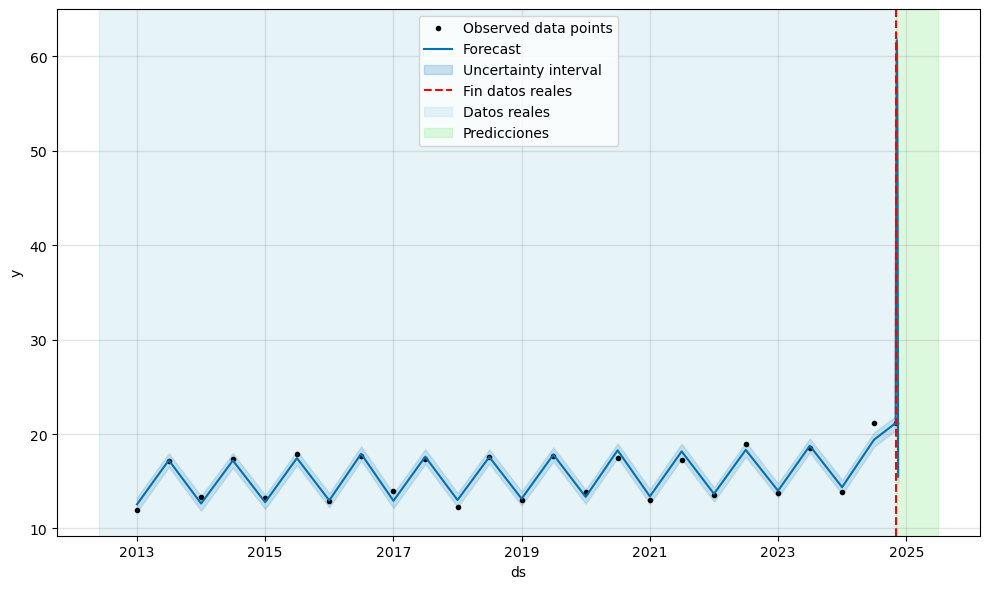

In [15]:
# Crear el gráfico de Prophet
fig = m.plot(forecast_biannual)

# Obtener el eje actual del gráfico
ax = fig.gca()

# Definir la fecha límite entre datos reales y predicciones
cutoff_date = df_biannual['ds'].max()

# Añadir una línea vertical para marcar la separación
ax.axvline(x=date2num(cutoff_date), color='red', linestyle='--', label='Fin datos reales')

# Sombrear la zona de datos reales
ax.axvspan(ax.get_xlim()[0], date2num(cutoff_date), color='lightblue', alpha=0.3, label='Datos reales')

# Sombrear la zona de predicciones
ax.axvspan(date2num(cutoff_date), ax.get_xlim()[1], color='lightgreen', alpha=0.3, label='Predicciones')

# Añadir una leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

In [16]:
forecast_biannual = m.predict(future)
forecast_biannual[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
34,2024-11-11,51.480779,50.676138,52.201688
35,2024-11-12,44.479200,43.713674,45.242583
36,2024-11-13,35.976236,35.265357,36.695748
37,2024-11-14,26.216267,25.526732,26.974895
38,2024-11-15,15.478916,14.741333,16.195011


/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

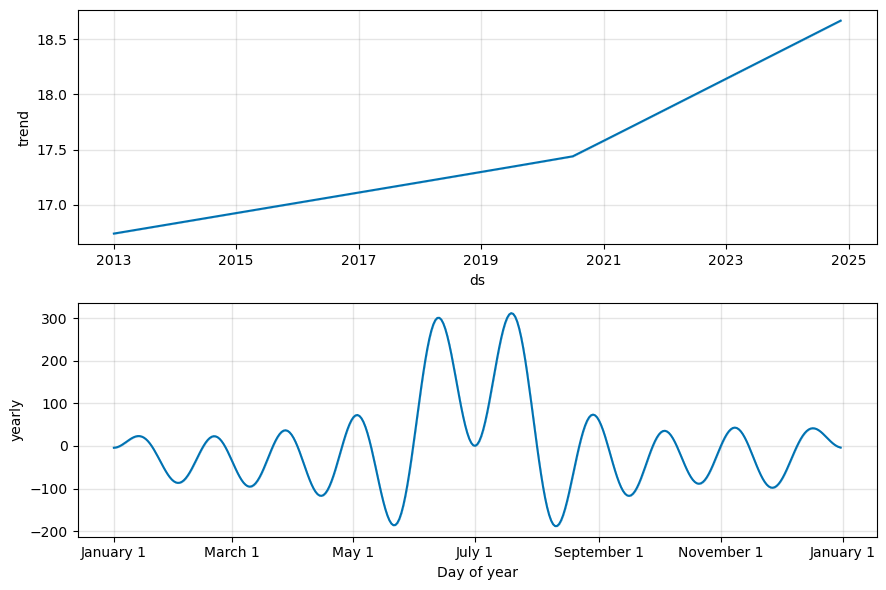

In [17]:
fig2 = m.plot_components(forecast_biannual)

# TRIMESTRAL:

In [19]:
df3 = df.copy()

In [20]:
df3['fecha'] = df3['fecha'].dt.to_period('Q').apply(lambda r: r.start_time)
df3 = df3.groupby("fecha").agg({"tmed":"mean"}).reset_index()
df3

,fecha,tmed
0,2013-01-01,8.819638
1,2013-04-01,15.011527
2,2013-07-01,22.414274
3,2013-10-01,11.868290
4,2014-01-01,9.551493
5,2014-04-01,16.970295
6,2014-07-01,21.681875
7,2014-10-01,12.966418
8,2015-01-01,8.788659
9,2015-04-01,17.586427


In [21]:
#sacar df entre df3 y df
last_date_df = df3["fecha"].max()
df_filtered = df[df["fecha"] > last_date_df]
df_filtered

# Ordena el nuevo DataFrame por fecha (si no está ordenado)
df_filtered = df_filtered.sort_values(by="fecha")

# Obtén la última fecha del nuevo Dataframe.
ultima_fecha = df_filtered["fecha"].max()

# Filtra las filas correspondientes a la última fecha
df_ultima_fecha = df_filtered[df_filtered["fecha"] == ultima_fecha]

# Calcula el promedio de la columna 'tmed' para esa fecha
promedio_tmed = df_filtered["tmed"].mean()

# Crea una fila con el promedio
resultado = pd.DataFrame({"fecha": [ultima_fecha], "tmed": [promedio_tmed]})

df_quarterly = pd.concat([df3,resultado])
df_quarterly = df_quarterly.reset_index(drop=True)
df_quarterly.rename(columns={"fecha": "ds", "tmed": "y"}, inplace=True)

In [22]:
df_quarterly

,ds,y
0,2013-01-01,8.819638
1,2013-04-01,15.011527
2,2013-07-01,22.414274
3,2013-10-01,11.868290
4,2014-01-01,9.551493
5,2014-04-01,16.970295
6,2014-07-01,21.681875
7,2014-10-01,12.966418
8,2015-01-01,8.788659
9,2015-04-01,17.586427


In [23]:
#MODELO

m = Prophet()
m.fit(df_quarterly)

22:30:23 - cmdstanpy - INFO - Chain [1] start processing
22:30:24 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
joblib.dump(m, 'prophet_quarterly.pkl')

print("Modelo guardado con joblib")

Modelo guardado con joblib


In [25]:
future = m.make_future_dataframe(periods=14)
future.tail()

,ds
58,2024-11-11
59,2024-11-12
60,2024-11-13
61,2024-11-14
62,2024-11-15


In [26]:
forecast_quarterly = m.predict(future)
forecast_quarterly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
58,2024-11-11,-352.322705,-353.176676,-351.411279
59,2024-11-12,-368.114997,-368.940484,-367.215333
60,2024-11-13,-378.154748,-379.026016,-377.341784
61,2024-11-14,-382.229930,-383.087347,-381.359469
62,2024-11-15,-380.229008,-381.046797,-379.402802


/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


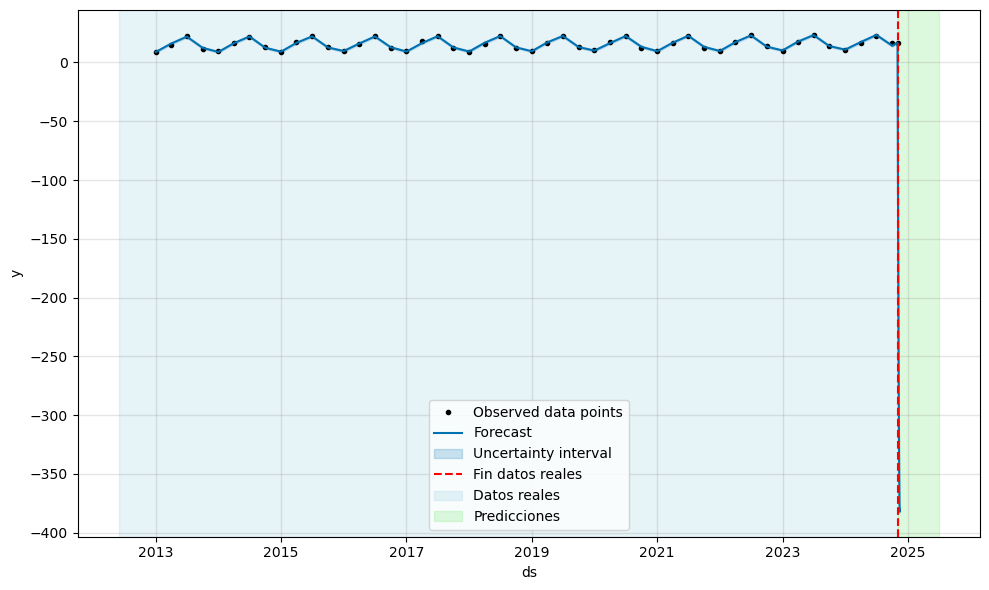

In [27]:
# Crear el gráfico de Prophet
fig = m.plot(forecast_quarterly)

# Obtener el eje actual del gráfico
ax = fig.gca()

# Definir la fecha límite entre datos reales y predicciones
cutoff_date = df_quarterly['ds'].max()

# Añadir una línea vertical para marcar la separación
ax.axvline(x=date2num(cutoff_date), color='red', linestyle='--', label='Fin datos reales')

# Sombrear la zona de datos reales
ax.axvspan(ax.get_xlim()[0], date2num(cutoff_date), color='lightblue', alpha=0.3, label='Datos reales')

# Sombrear la zona de predicciones
ax.axvspan(date2num(cutoff_date), ax.get_xlim()[1], color='lightgreen', alpha=0.3, label='Predicciones')

# Añadir una leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

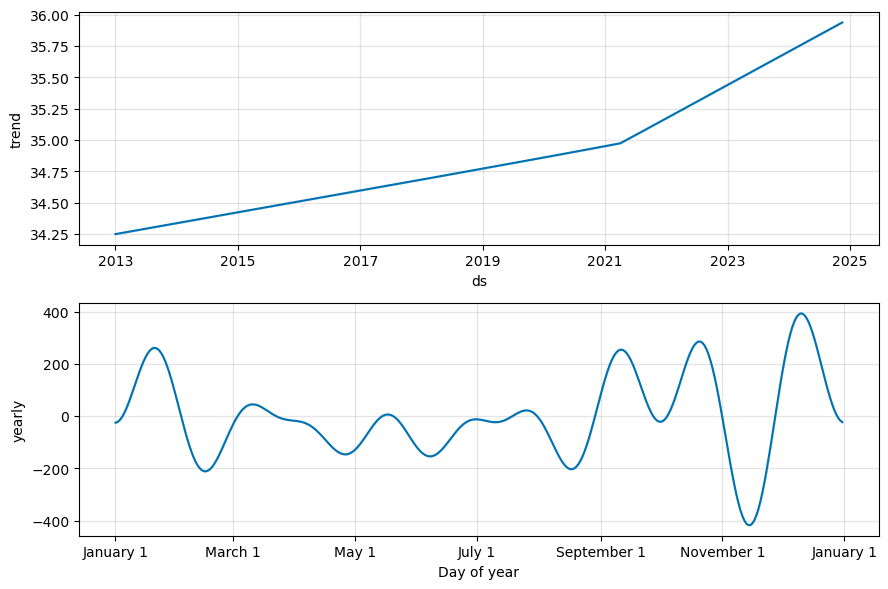

In [28]:
fig2 = m.plot_components(forecast_quarterly)

# MENSUAL:

In [30]:
df5 = df.copy()

In [31]:
df5['fecha'] = df5['fecha'].dt.to_period('M').apply(lambda r: r.start_time)
df5 = df5.groupby("fecha").agg({"tmed":"mean"}).reset_index()

In [32]:
#sacar df entre df5 y df
last_date_df = df5["fecha"].max()
df_filtered = df[df["fecha"] > last_date_df]
df_filtered

# Ordena el nuevo DataFrame por fecha (si no está ordenado)
df_filtered = df_filtered.sort_values(by="fecha")

# Obtén la última fecha del nuevo Dataframe.
ultima_fecha = df_filtered["fecha"].max()

# Filtra las filas correspondientes a la última fecha
df_ultima_fecha = df_filtered[df_filtered["fecha"] == ultima_fecha]

# Calcula el promedio de la columna 'tmed' para esa fecha
promedio_tmed = df_filtered["tmed"].mean()

# Crea una fila con el promedio
resultado = pd.DataFrame({"fecha": [ultima_fecha], "tmed": [promedio_tmed]})

df_monthly = pd.concat([df5,resultado])
df_monthly = df_monthly.reset_index(drop=True)
df_monthly.rename(columns={"fecha": "ds", "tmed": "y"}, inplace=True)

In [33]:
#MODELO

m = Prophet()
m.fit(df_monthly)

22:32:30 - cmdstanpy - INFO - Chain [1] start processing
22:32:30 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
joblib.dump(m, 'prophet_monthly.pkl')

print("Modelo guardado con joblib")

Modelo guardado con joblib


In [35]:
future = m.make_future_dataframe(periods=14)
future.tail()

,ds
152,2024-11-11
153,2024-11-12
154,2024-11-13
155,2024-11-14
156,2024-11-15


In [36]:
forecast_monthly = m.predict(future)
forecast_monthly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
152,2024-11-11,19.360736,18.055785,20.711512
153,2024-11-12,19.577786,18.311517,20.853413
154,2024-11-13,19.695220,18.391004,21.032382
155,2024-11-14,19.711361,18.432595,20.991680
156,2024-11-15,19.626224,18.348243,20.939270


/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


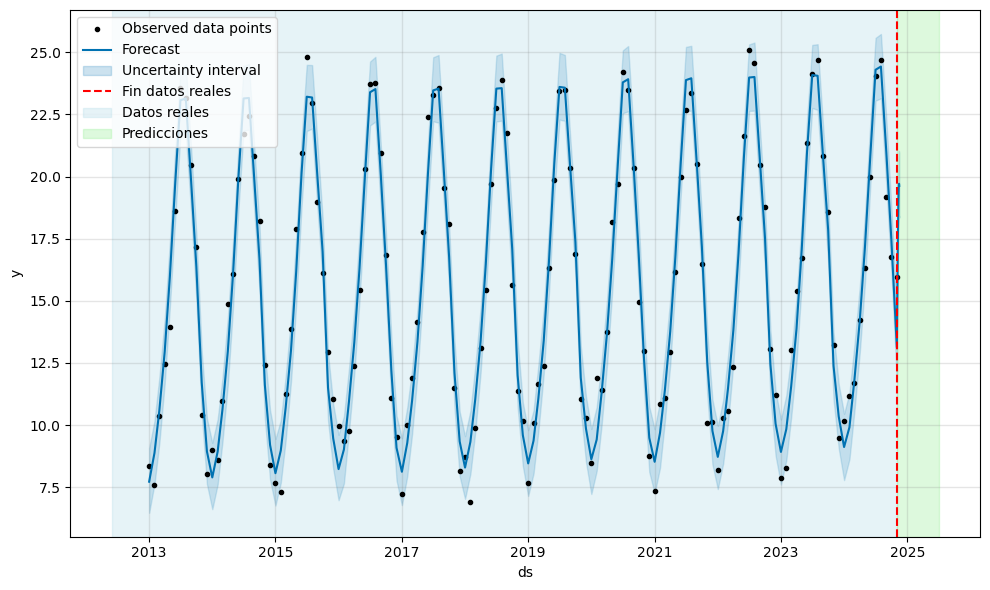

In [37]:
# Crear el gráfico de Prophet
fig = m.plot(forecast_monthly)

# Obtener el eje actual del gráfico
ax = fig.gca()

# Definir la fecha límite entre datos reales y predicciones
cutoff_date = df_monthly['ds'].max()

# Añadir una línea vertical para marcar la separación
ax.axvline(x=date2num(cutoff_date), color='red', linestyle='--', label='Fin datos reales')

# Sombrear la zona de datos reales
ax.axvspan(ax.get_xlim()[0], date2num(cutoff_date), color='lightblue', alpha=0.3, label='Datos reales')

# Sombrear la zona de predicciones
ax.axvspan(date2num(cutoff_date), ax.get_xlim()[1], color='lightgreen', alpha=0.3, label='Predicciones')

# Añadir una leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

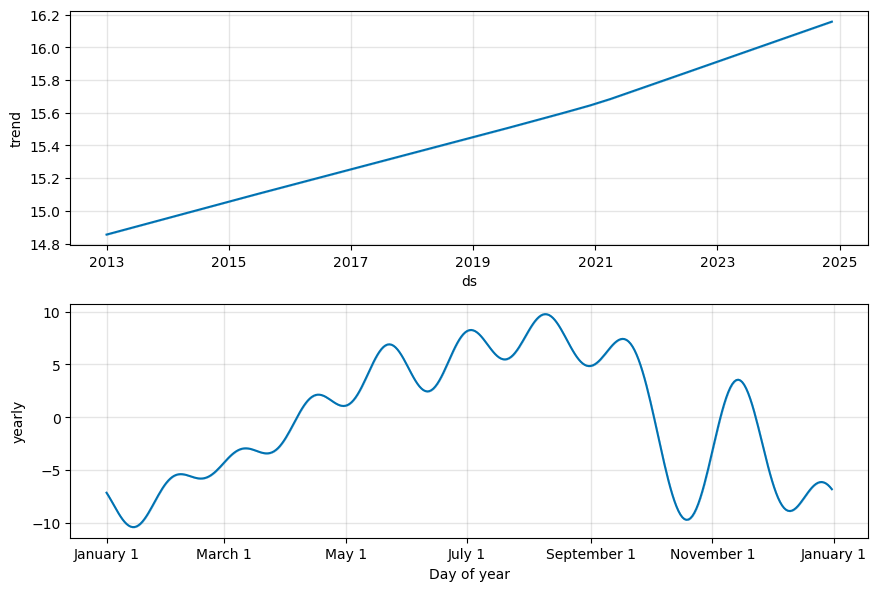

In [38]:
fig2 = m.plot_components(forecast_monthly)

# SEMANAL:

In [40]:
df7 = df.copy()

In [41]:
df7['fecha'] = df7['fecha'].dt.to_period('W').apply(lambda r: r.start_time)
df7 = df7.groupby("fecha").agg({"tmed":"mean"}).reset_index()

In [42]:
#sacar df entre df7 y df
last_date_df = df7["fecha"].max()
df_filtered = df[df["fecha"] > last_date_df]
df_filtered

# Ordena el nuevo DataFrame por fecha (si no está ordenado)
df_filtered = df_filtered.sort_values(by="fecha")

# Obtén la última fecha del nuevo Dataframe.
ultima_fecha = df_filtered["fecha"].max()

# Filtra las filas correspondientes a la última fecha
df_ultima_fecha = df_filtered[df_filtered["fecha"] == ultima_fecha]

# Calcula el promedio de la columna 'tmed' para esa fecha
promedio_tmed = df_filtered["tmed"].mean()

# Crea una fila con el promedio
resultado = pd.DataFrame({"fecha": [ultima_fecha], "tmed": [promedio_tmed]})

df_weekly = pd.concat([df7,resultado])
df_weekly = df_weekly.reset_index(drop=True)
df_weekly.rename(columns={"fecha": "ds", "tmed": "y"}, inplace=True)

In [43]:
#MODELO

m = Prophet()
m.fit(df_weekly)

22:34:37 - cmdstanpy - INFO - Chain [1] start processing
22:34:37 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
joblib.dump(m, 'prophet_weekly.pkl')

print("Modelo guardado con joblib")

Modelo guardado con joblib


In [45]:
future = m.make_future_dataframe(periods=14)
future.tail()

,ds
628,2024-11-11
629,2024-11-12
630,2024-11-13
631,2024-11-14
632,2024-11-15


In [46]:
forecast_weekly = m.predict(future)
forecast_weekly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
628,2024-11-11,12.659760,10.605175,14.650860
629,2024-11-12,7.718477,5.487205,9.828258
630,2024-11-13,7.528270,5.342749,9.615923
631,2024-11-14,7.339366,5.283967,9.425162
632,2024-11-15,12.871200,10.935852,14.849573


/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


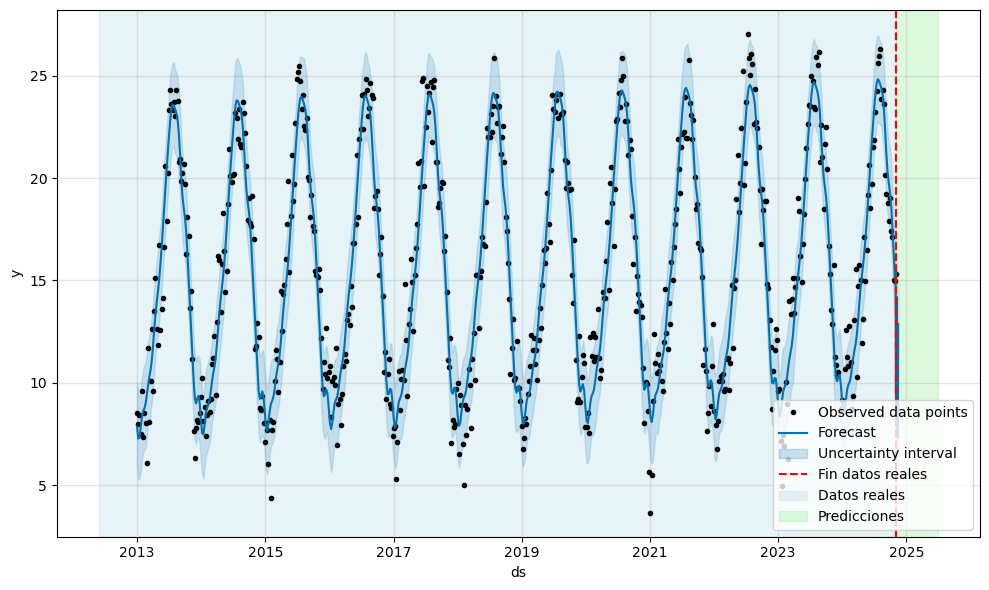

In [47]:
# Crear el gráfico de Prophet
fig = m.plot(forecast_weekly)

# Obtener el eje actual del gráfico
ax = fig.gca()

# Definir la fecha límite entre datos reales y predicciones
cutoff_date = df_weekly['ds'].max()

# Añadir una línea vertical para marcar la separación
ax.axvline(x=date2num(cutoff_date), color='red', linestyle='--', label='Fin datos reales')

# Sombrear la zona de datos reales
ax.axvspan(ax.get_xlim()[0], date2num(cutoff_date), color='lightblue', alpha=0.3, label='Datos reales')

# Sombrear la zona de predicciones
ax.axvspan(date2num(cutoff_date), ax.get_xlim()[1], color='lightgreen', alpha=0.3, label='Predicciones')

# Añadir una leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior,

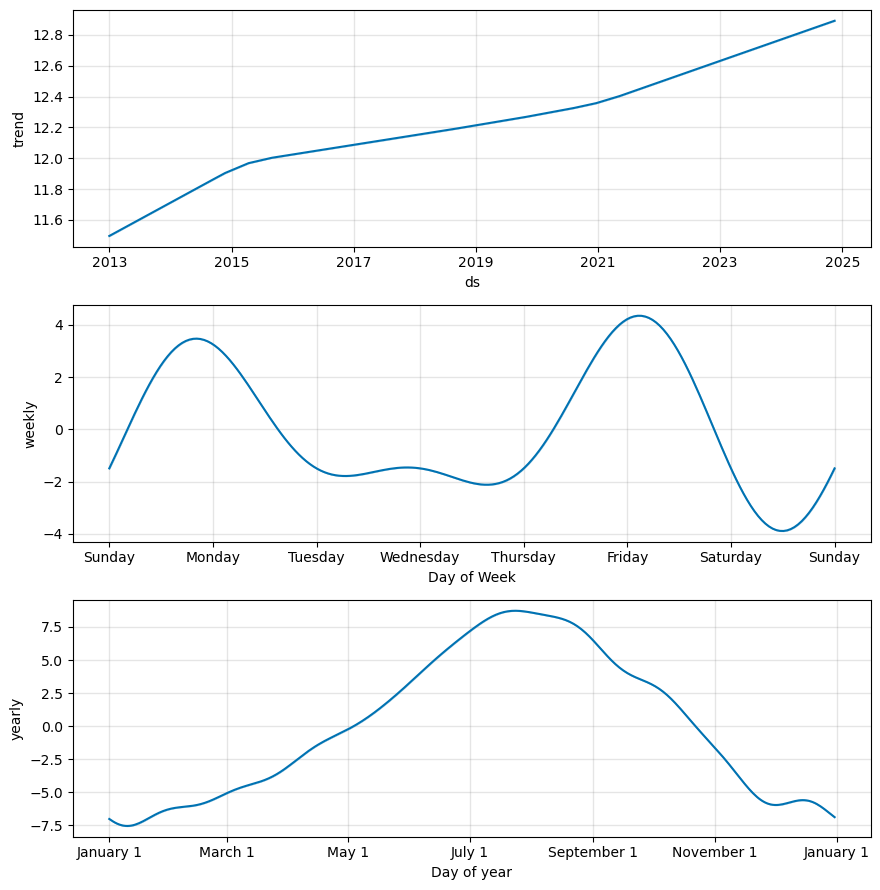

In [48]:
fig2 = m.plot_components(forecast_weekly)

# DIARIO:

In [50]:
df9 = df.copy()

In [51]:
df9['fecha'] = df9['fecha'].dt.to_period('D').apply(lambda r: r.start_time)
df9 = df9.groupby("fecha").agg({"tmed":"mean"}).reset_index()

In [52]:
#sacar df entre df9 y df
last_date_df = df9["fecha"].max()
df_filtered = df[df["fecha"] > last_date_df]
df_filtered

# Ordena el nuevo DataFrame por fecha (si no está ordenado)
df_filtered = df_filtered.sort_values(by="fecha")

# Obtén la última fecha del nuevo Dataframe.
ultima_fecha = df_filtered["fecha"].max()

# Filtra las filas correspondientes a la última fecha
df_ultima_fecha = df_filtered[df_filtered["fecha"] == ultima_fecha]

# Calcula el promedio de la columna 'tmed' para esa fecha
promedio_tmed = df_filtered["tmed"].mean()

# Crea una fila con el promedio
resultado = pd.DataFrame({"fecha": [ultima_fecha], "tmed": [promedio_tmed]})

df_daily = pd.concat([df9,resultado])
df_daily = df_daily.reset_index(drop=True)
df_daily.rename(columns={"fecha": "ds", "tmed": "y"}, inplace=True)

In [53]:
#MODELO

m = Prophet()
m.fit(df_daily)

22:36:44 - cmdstanpy - INFO - Chain [1] start processing
22:36:44 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
joblib.dump(m, 'prophet_daily.pkl')

print("Modelo guardado con joblib")

Modelo guardado con joblib


In [55]:
future = m.make_future_dataframe(periods=14)
future.tail()

,ds
4332,2024-11-11
4333,2024-11-12
4334,2024-11-13
4335,2024-11-14
4336,2024-11-15


In [56]:
forecast_daily = m.predict(future)
forecast_daily[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4332,2024-11-11,13.176162,10.427009,15.736585
4333,2024-11-12,12.972305,10.200812,15.586855
4334,2024-11-13,12.858696,10.353265,15.412052
4335,2024-11-14,12.724281,9.983667,15.299652
4336,2024-11-15,12.471622,9.820120,15.038570


/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


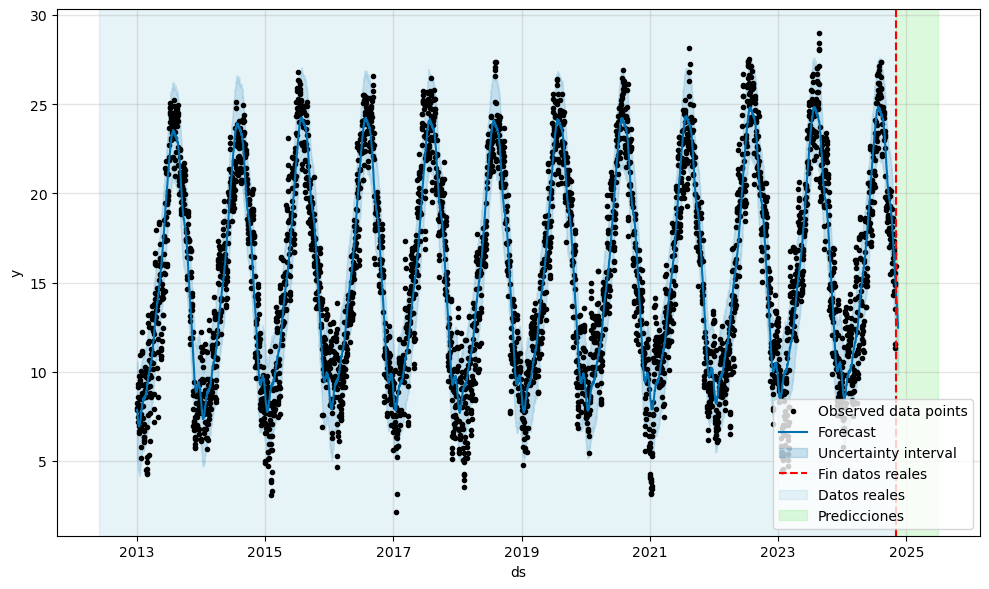

In [57]:
# Crear el gráfico de Prophet
fig = m.plot(forecast_daily)

# Obtener el eje actual del gráfico
ax = fig.gca()

# Definir la fecha límite entre datos reales y predicciones
cutoff_date = df_daily['ds'].max()

# Añadir una línea vertical para marcar la separación
ax.axvline(x=date2num(cutoff_date), color='red', linestyle='--', label='Fin datos reales')

# Sombrear la zona de datos reales
ax.axvspan(ax.get_xlim()[0], date2num(cutoff_date), color='lightblue', alpha=0.3, label='Datos reales')

# Sombrear la zona de predicciones
ax.axvspan(date2num(cutoff_date), ax.get_xlim()[1], color='lightgreen', alpha=0.3, label='Predicciones')

# Añadir una leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

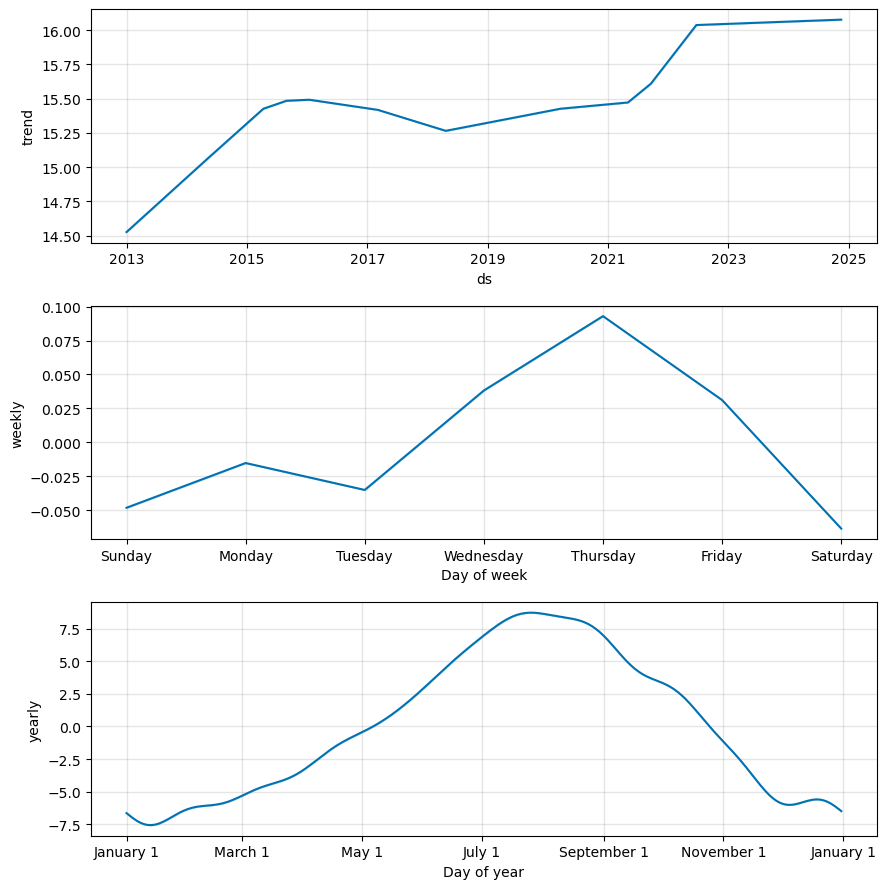

In [58]:
fig2 = m.plot_components(forecast_daily)